# Seam Carving

Seam carving je algoritam koji se koristi za promenu veličine slike tako da bitni delovi slike ostaju nepromenjeni. 

Najprostije rečeno, računa koji horizontalni redovi piksela imaju najmanju "težinu", potom ih uklanja ili dodaje da bi promenio veličinu slike.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from skimage import io, util
from tqdm import trange
from imageio import imread
from scipy.ndimage.filters import convolve

def imread(filename):
    """For convenience since pixels are natively 8 bit ints"""
    return util.img_as_float(io.imread(filename))

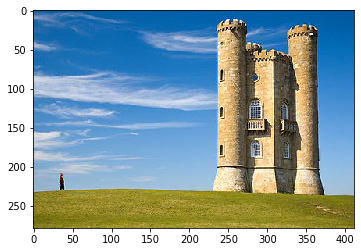

In [2]:
tower = imread('tower.jpg')
plt.imshow(tower)

In [3]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

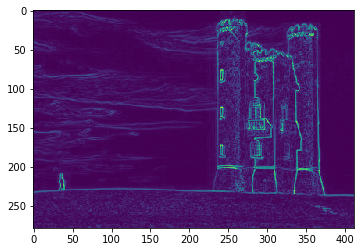

In [5]:
plt.imshow(calc_energy(tower))

In [6]:
def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index a -1
            if j == 0:
                idx = np.argmin(M[i-1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

In [7]:
def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)

    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))

    return img

In [14]:
def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in trange(c - new_c):
        img = carve_column(img)

    return img

def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img

100%|██████████| 124/124 [00:34<00:00,  3.56it/s]


Wall time: 34.8 s


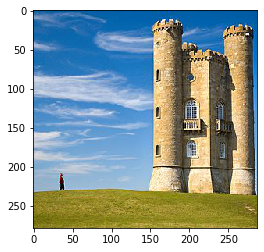

In [9]:
%time plt.imshow(crop_c(tower, 0.7))

Primeri seam carving algoritma

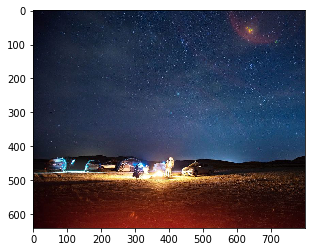

In [12]:
night = imread('night.jpg')
plt.imshow(night)

100%|██████████| 192/192 [04:17<00:00,  1.34s/it]


Wall time: 4min 17s


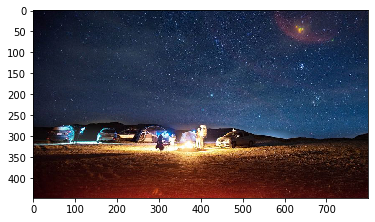

In [15]:
%time plt.imshow(crop_r(night, 0.7))

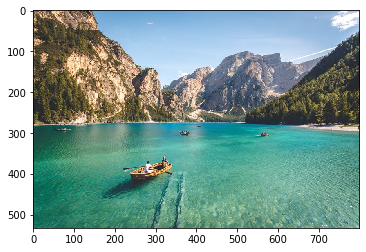

In [16]:
lake = imread('lake.jpg')
plt.imshow(lake)

100%|██████████| 240/240 [04:25<00:00,  1.11s/it]


Wall time: 4min 25s


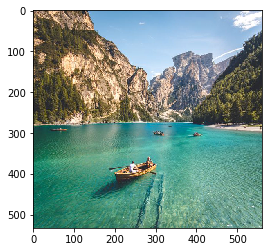

In [18]:
%time plt.imshow(crop_c(lake, 0.7))